### Testing out pytorch geometric on finding MW streams
This is somewhat related to Claudia's problem but at this stage it's mostly and exercise to get a feeling of how pyg works. The idea is to generate a bunch of stars that are initially organized in clusters, and evolve their orbits in the Galactic potential for a while. There is no self gravity, so the clusters are disrupted pretty quickly.
Given the 6-D phase space information for these evolved stars and some labeled stars, can a graph convolutional network correctly tag the other stars, i.e. find their birth cluster?

In [1]:
%matplotlib inline
import torch
from torchmetrics import Accuracy, AUC, ConfusionMatrix
import seaborn as sn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from galpy.orbit import Orbit
from torch_cluster import knn_graph
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
from sklearn.datasets import make_blobs as mb
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from galpy.potential.mwpotentials import McMillan17
from sklearn.preprocessing import StandardScaler
from galpy.util.conversion import get_physical

Here I am generating 500 stars organized in 5 clusters. They start on solar-system like Galactic orbits, that is mostly circular and in the plane (with some scatter). Initial conditions are visualized in the native galpy coordinates (R,vR,vT,z,vz,phi).

In [2]:
np.random.seed(8) #set seed
n_centers = 5
n_stars = 500
blobs = mb(n_stars,n_features=6,centers=n_centers) #make blobs
ss = StandardScaler()
ss.fit(blobs[0])
coordinates = ss.transform(blobs[0])/20.0 #point coordinates
coordinates[:,0] = 1.0 + coordinates[:,0]
coordinates[:,2] = 1.0 + coordinates[:,2]
labels = blobs[1] #group labels
#for i in range(coordinates.shape[1]):
#    for j in range(i):
#        plt.scatter(coordinates[:,i], coordinates[:,j], c = labels) #show
#        plt.show()



array([1, 4, 0, 0, 4, 0, 2, 3, 3, 3, 4, 3, 4, 1, 0, 4, 3, 1, 1, 4, 0, 4,
       2, 3, 2, 2, 1, 2, 4, 4, 0, 4, 3, 0, 3, 3, 0, 3, 3, 4, 0, 3, 3, 3,
       0, 3, 2, 2, 0, 1, 4, 2, 2, 0, 4, 1, 0, 2, 1, 0, 3, 1, 3, 3, 1, 3,
       2, 1, 1, 3, 1, 3, 3, 2, 3, 0, 4, 2, 0, 0, 3, 1, 3, 1, 3, 3, 3, 3,
       0, 1, 2, 2, 2, 1, 4, 1, 0, 3, 1, 3, 0, 0, 4, 3, 1, 3, 3, 1, 2, 2,
       1, 3, 3, 3, 0, 1, 2, 0, 2, 0, 4, 1, 4, 4, 4, 4, 1, 3, 0, 0, 1, 2,
       2, 2, 2, 2, 3, 2, 0, 3, 0, 1, 2, 4, 0, 1, 4, 0, 2, 2, 0, 3, 0, 4,
       3, 1, 0, 1, 3, 3, 3, 1, 1, 4, 2, 0, 3, 0, 3, 0, 1, 2, 2, 1, 2, 4,
       0, 3, 1, 0, 2, 3, 4, 2, 0, 4, 3, 1, 2, 1, 0, 2, 4, 1, 4, 2, 1, 4,
       1, 1, 2, 1, 1, 3, 0, 0, 2, 3, 4, 2, 4, 2, 2, 4, 4, 0, 2, 3, 0, 0,
       4, 4, 1, 0, 2, 4, 1, 2, 0, 4, 4, 0, 0, 0, 3, 2, 3, 4, 3, 2, 1, 0,
       1, 4, 2, 4, 3, 1, 2, 4, 4, 1, 4, 1, 0, 1, 4, 3, 4, 4, 4, 1, 4, 0,
       1, 1, 4, 1, 4, 4, 2, 2, 2, 2, 2, 3, 1, 2, 3, 1, 3, 0, 0, 2, 4, 4,
       0, 2, 2, 2, 2, 1, 1, 1, 4, 1, 3, 3, 3, 0, 1,

In [5]:
np.max(labels)+1

5

Then they get evolved in the McMillan17 potential from galpy. The final coordinates (used for training) are distance, RA, Dec, pmRA, pmDec, and line-of-sight velocity

Initial coordinates (never used in training)


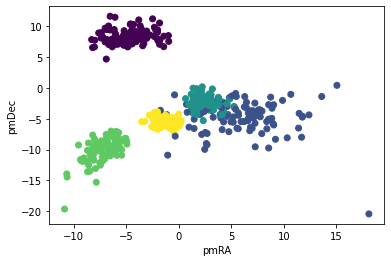

Evolved coordinates (used in training)


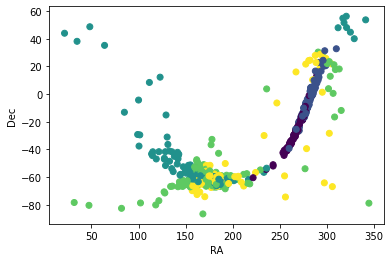

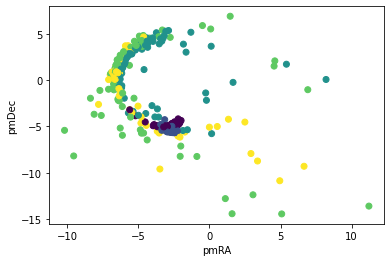

In [6]:
McMillanEarth = get_physical(McMillan17)
o = Orbit(coordinates, ro=McMillanEarth['ro'],vo=McMillanEarth['vo'])
T = 40.0
dT = 0.05
t = np.arange(0,T+dT,dT)
o.integrate(t, McMillan17)

print("Initial coordinates (never used in training)")
plt.scatter(o.ra(0), o.dec(0), c=labels)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()
plt.scatter(o.pmra(0), o.pmdec(0), c=labels)
plt.xlabel('pmRA')
plt.ylabel('pmDec')
plt.show()

print("Evolved coordinates (used in training)")
plt.scatter(o.ra(T), o.dec(T), c=labels)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()
plt.scatter(o.pmra(T), o.pmdec(T), c=labels)
plt.xlabel('pmRA')
plt.ylabel('pmDec')
plt.show()

new_coordinates = [o.ra(T), o.dec(T), o.dist(T), o.pmra(T), o.pmdec(T), o.vlos(T)]
ss2 = StandardScaler()
ss2.fit(new_coordinates)
new_coordinates = ss2.transform(new_coordinates)

In [35]:
def return_train_test_validation_vassilli(coordinates, labels):
    dists = np.zeros(labels.shape[0])
    for i in range(np.max(labels)):
        dRA = (coordinates[labels==i,0] - np.mean(coordinates[labels==i,0],axis=0))/np.std(coordinates[labels==i,0],axis=0)
        dDec = (coordinates[labels==i,1] - np.mean(coordinates[labels==i,1],axis=0))/np.std(coordinates[labels==i,1],axis=0)
        dists[labels==i] = dRA*dRA + dDec*dDec
    train_test_validation = np.random.choice(['test', 'validation'], labels.shape) 
    train_test_validation[dists<np.quantile(dists, 0.5)] = 'train'
    return train_test_validation

return_train_test_validation_vassilli(coordinates, labels)

array(['train', 'train', 'validation', 'validation', 'train', 'train',
       'train', 'train', 'validation', 'test', 'train', 'validation',
       'train', 'train', 'validation', 'train', 'validation', 'train',
       'test', 'train', 'validation', 'train', 'validation', 'test',
       'test', 'train', 'train', 'test', 'train', 'train', 'train',
       'train', 'test', 'validation', 'validation', 'validation', 'test',
       'test', 'test', 'train', 'test', 'train', 'test', 'test', 'test',
       'train', 'train', 'test', 'train', 'test', 'train', 'test',
       'train', 'validation', 'train', 'validation', 'test', 'test',
       'test', 'validation', 'test', 'train', 'validation', 'validation',
       'test', 'test', 'train', 'train', 'train', 'train', 'test',
       'train', 'test', 'train', 'test', 'train', 'train', 'test',
       'train', 'validation', 'validation', 'validation', 'validation',
       'test', 'train', 'train', 'train', 'train', 'train', 'train',
       'train', 'va

0.858208954334259


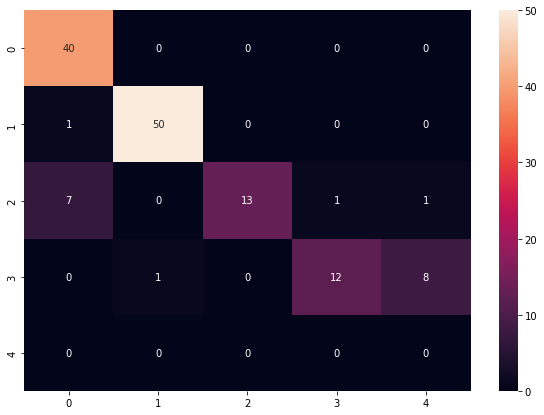

0.5882353186607361


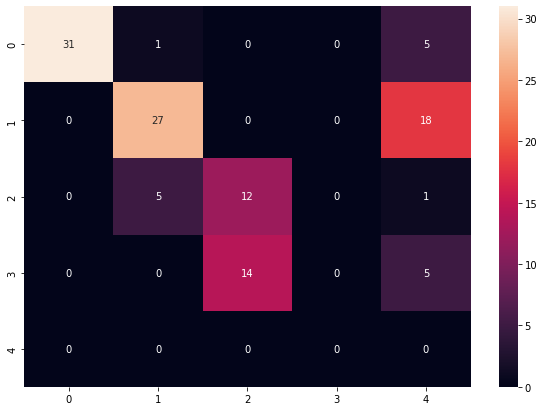

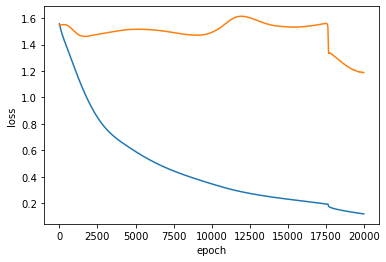

0.8373983502388


0.5045045018196106


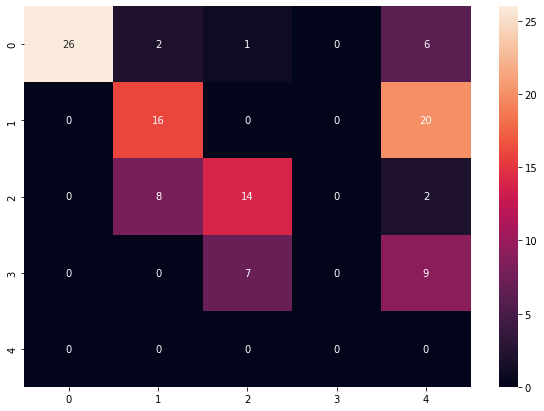

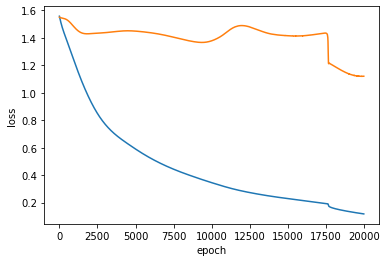

0.8285714387893677


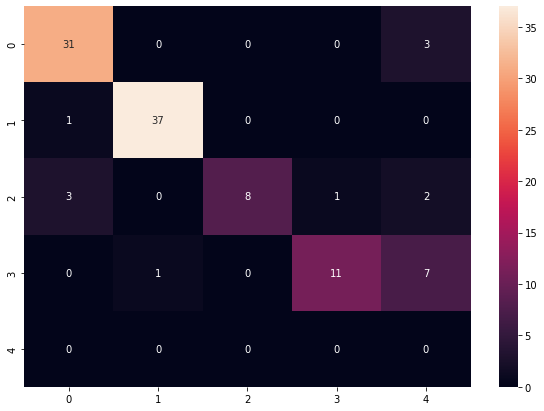

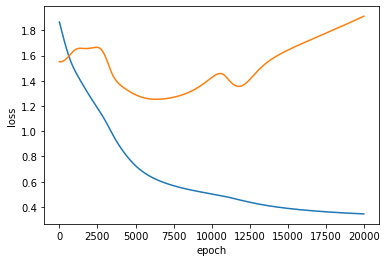

0.5629629492759705


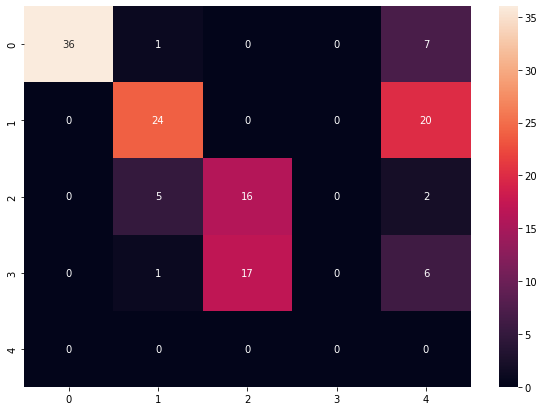

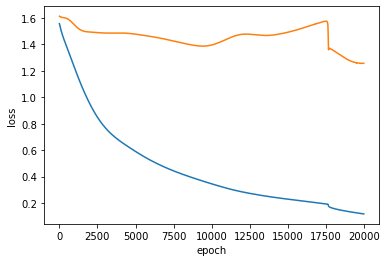

0.8083333373069763


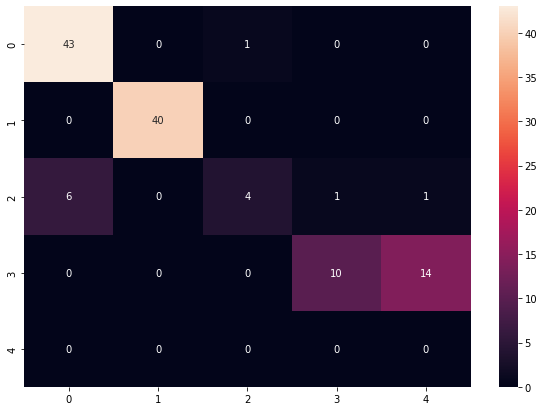

0.5267175436019897


0.8331280201673508 0.017908292140825708
0.5456050783395767 0.03226697007785767


In [38]:
torch.manual_seed(888)

def build_and_train(include_distance = True):
    if include_distance:
        new_coordinates = [o.ra(T), o.dec(T), o.dist(T), o.pmra(T), o.pmdec(T), o.vlos(T)]
    else:
        new_coordinates = [o.ra(T), o.dec(T), o.pmra(T), o.pmdec(T), o.vlos(T)]        
    ss2 = StandardScaler()
    ss2.fit(new_coordinates)
    new_coordinates = ss2.transform(new_coordinates)
    new_coordinates = np.transpose(np.array(new_coordinates))
    x = torch.Tensor(new_coordinates)
    assign_train_test_val = return_train_test_validation_vassilli(new_coordinates, labels)
    train_mask=torch.Tensor(assign_train_test_val == 'train')
    train_mask=train_mask.type(dtype=torch.bool)
    validation_mask=torch.Tensor(assign_train_test_val == 'validation')
    validation_mask=validation_mask.type(dtype=torch.bool)
    edge_index = knn_graph(x, k=4)
    y = torch.Tensor(labels)
    y = y.type(dtype=torch.long)
    P = Data(x=x, y=y, edge_index=edge_index, train_mask=train_mask, validation_mask=validation_mask)

    class GCN(torch.nn.Module):
        def __init__(self):
            super().__init__()
            torch.manual_seed(888)
            self.conv1 = GCNConv(P.num_features, 12)
            self.conv2 = GCNConv(12, 6)
            self.conv3 = GCNConv(6, 3)
            self.classifier = Linear(3, n_centers) #numero di classi

        def forward(self, x, edge_index):
            h = self.conv1(x, edge_index)
            h = h.tanh()
            h = self.conv2(h, edge_index)
            h = h.tanh()
            h = self.conv3(h, edge_index)
            h = h.tanh()  # Final GNN embedding space.
        
            # Apply a final (linear) classifier.
            out = self.classifier(h)

            return out, h

    model = GCN()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    out, h = model(P.x, P.edge_index)

    def train(data):
        optimizer.zero_grad()
        out, h = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        return loss, h

    epochs = np.arange(20001)
    losses = np.zeros(shape=epochs.shape)
    vallosses = np.zeros(shape=epochs.shape)
    for epoch in epochs:
        loss, h = train(P)
        #visualize_embedding(h, color=P.y, epoch=epoch, loss=loss)
        outval, hval = model(P.x, P.edge_index)
        lossval = criterion(outval[P.validation_mask], P.y[P.validation_mask])
        losses[epoch] = loss.item()
        vallosses[epoch] = lossval.item()
        #print(epoch, losses[epoch], vallosses[epoch])

    plt.plot(epochs, losses)
    plt.plot(epochs, vallosses)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

    def visualize_embedding(h, color, epoch=None, loss=None):
        '''Visualize the embedding of the graph from a given GCN'''
        h = h.detach().cpu().numpy()
        for i in range(h.shape[1]):
            for j in range(i):
                plt.scatter(h[:,i], h[:,j], s=140, c = color, cmap="Set2") #show
                plt.show()
            
    #visualize_embedding(h, color=P.y, epoch=epoch, loss=loss)
    
    accuracy_metric = Accuracy()
    confusion_matrix = ConfusionMatrix(5)
    accu = accuracy_metric(outval[P.validation_mask], P.y[P.validation_mask]).item()
    print(accu)
    plt.figure(figsize=(10,7))
    sn.heatmap(confusion_matrix(outval[P.validation_mask], P.y[P.validation_mask]), annot=True)
    plt.show()
    return epochs, vallosses, accu

Nruns = 3

epochs_all, losses_all, aa = build_and_train()
epochs_nodistance, losses_nodistance, an = build_and_train(include_distance = False)

accu_all = [aa]
accu_nodistance = [an]

for i in range(1):    
    e, l, a = build_and_train()
    losses_all += l
    accu_all.append(a)
    e, l, a = build_and_train(include_distance = False)
    accu_nodistance.append(a)
    losses_nodistance += l
    
    
losses_all = losses_all/(1+Nruns)
losses_nodistance = losses_nodistance/(1+Nruns)

plt.plot(epochs_all, losses_all, color="#4124F5")
plt.plot(epochs_nodistance, losses_nodistance, color="#222223")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

accu_all = np.array(accu_all)
accu_nodistance = np.array(accu_nodistance)

print(accu_all.mean(), accu_all.std())
print(accu_nodistance.mean(), accu_nodistance.std())

In [39]:
L = len(o.ra(T))
[0.1*o.ra(T).std()*np.random.normal(size=L), 0.1*o.dec(T).std()*np.random.normal(size=L), 0.1*o.dist(T).std()*np.random.normal(size=L), 0.1*o.pmra(T).std()*np.random.normal(size=L), 0.1*o.pmdec(T).std()*np.random.normal(size=L), 0.1*o.vlos(T).std()*np.random.normal(size=L)]



[array([-1.70520162e+00, -2.20776260e+00, -3.02598296e+00,  5.72963160e+00,
         3.88885950e+00,  2.91543523e-01,  5.75773890e+00, -1.39630853e+00,
         1.10141096e+01, -7.22898104e+00,  6.01355753e+00,  6.54624710e+00,
         1.82506102e+00, -4.77034743e+00, -3.45322956e+00,  7.97481428e-02,
         7.87953815e+00,  5.86855001e+00, -8.21410382e+00, -7.33585486e+00,
         5.83143768e-01,  1.02445511e+01,  8.75987788e+00, -2.35285631e+00,
        -4.84160931e+00,  3.73141915e+00,  8.64185427e+00,  4.41142439e+00,
        -5.45623522e+00, -6.47675401e+00,  8.10793214e+00,  4.59342727e+00,
        -7.53491932e+00,  5.13036511e+00,  1.17807577e+00,  1.85404977e+00,
        -1.07987317e+00,  4.58875751e+00, -1.56434523e+01, -3.25116647e+00,
         2.15270476e+00, -3.70326004e+00,  3.46871572e-01,  1.05601090e+01,
        -9.32408626e-01,  7.52595669e+00,  1.29569665e+00,  4.30872504e+00,
         3.58512643e+00,  1.67006067e+00,  3.50255760e+00,  1.23599929e+01,
         8.4

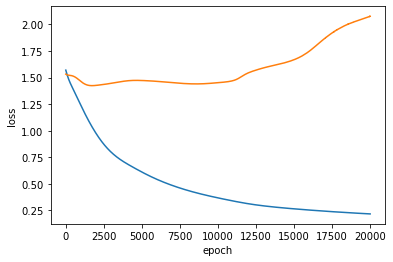

0.3777777850627899


0.6393442749977112


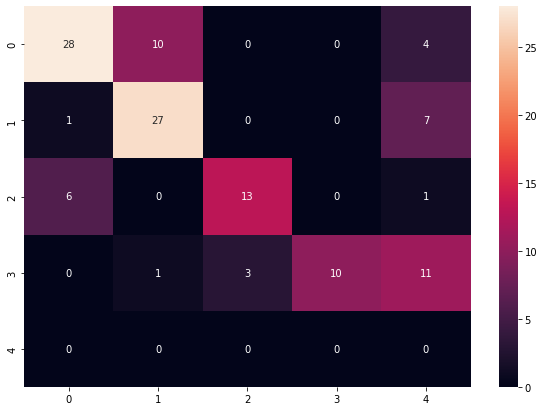

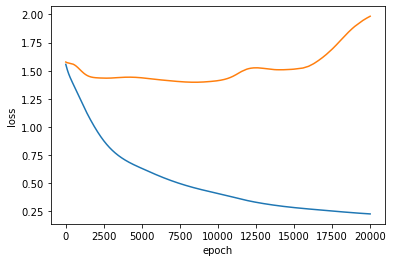

0.3813559412956238


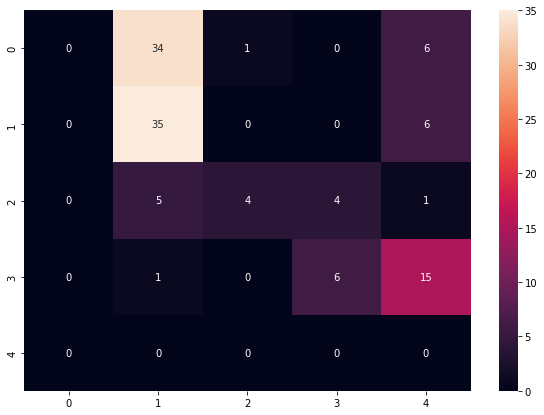

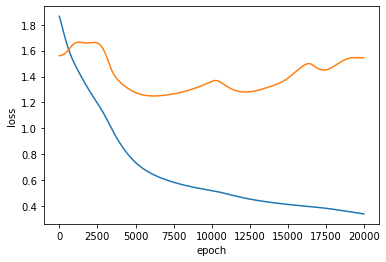

0.6141732335090637


0.37956686317920685 0.0017890781164169312
0.6267587542533875 0.01258552074432373


In [40]:
torch.manual_seed(888)

def build_and_train_noise(include_distance = True):
    L = len(o.ra(T))
    if include_distance:
        new_coordinates = [o.ra(T), o.dec(T), o.dist(T), o.pmra(T), o.pmdec(T), o.vlos(T)]
        noise = [0.1*o.ra(T).std()*np.random.normal(size=L), 0.1*o.dec(T).std()*np.random.normal(size=L), 0.1*o.dist(T).std()*np.random.normal(size=L), 0.1*o.pmra(T).std()*np.random.normal(size=L), 0.1*o.pmdec(T).std()*np.random.normal(size=L), 0.1*o.vlos(T).std()*np.random.normal(size=L)]
        new_coordinates = [o.ra(T) + noise[0], o.dec(T) + noise[1], o.dist(T) + noise[2], o.pmra(T) + noise[3], o.pmdec(T) + noise[4], o.vlos(T) + noise[5]]
    else:
        new_coordinates = [o.ra(T), o.dec(T), o.pmra(T), o.pmdec(T), o.vlos(T)]
        noise = [0.1*o.ra(T).std()*np.random.normal(size=L), 0.1*o.dec(T).std()*np.random.normal(size=L), 0.1*o.pmra(T).std()*np.random.normal(size=L), 0.1*o.pmdec(T).std()*np.random.normal(size=L), 0.1*o.vlos(T).std()*np.random.normal(size=L)]
        new_coordinates = [o.ra(T) + noise[0], o.dec(T) + noise[1], o.pmra(T) + noise[2], o.pmdec(T) + noise[3], o.vlos(T) + noise[4]]        
    ss2 = StandardScaler()
    ss2.fit(new_coordinates)
    new_coordinates = ss2.transform(new_coordinates)
    new_coordinates = np.transpose(np.array(new_coordinates))
    x = torch.Tensor(new_coordinates)
    assign_train_test_val = return_train_test_validation_vassilli(new_coordinates, labels)
    train_mask=torch.Tensor(assign_train_test_val == 'train')
    train_mask=train_mask.type(dtype=torch.bool)
    validation_mask=torch.Tensor(assign_train_test_val == 'validation')
    validation_mask=validation_mask.type(dtype=torch.bool)
    edge_index = knn_graph(x, k=4)
    y = torch.Tensor(labels)
    y = y.type(dtype=torch.long)
    P = Data(x=x, y=y, edge_index=edge_index, train_mask=train_mask, validation_mask=validation_mask)

    class GCN(torch.nn.Module):
        def __init__(self):
            super().__init__()
            torch.manual_seed(888)
            self.conv1 = GCNConv(P.num_features, 12)
            self.conv2 = GCNConv(12, 6)
            self.conv3 = GCNConv(6, 3)
            self.classifier = Linear(3, n_centers) #numero di classi

        def forward(self, x, edge_index):
            h = self.conv1(x, edge_index)
            h = h.tanh()
            h = self.conv2(h, edge_index)
            h = h.tanh()
            h = self.conv3(h, edge_index)
            h = h.tanh()  # Final GNN embedding space.
        
            # Apply a final (linear) classifier.
            out = self.classifier(h)

            return out, h

    model = GCN()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    out, h = model(P.x, P.edge_index)

    def train(data):
        optimizer.zero_grad()
        out, h = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        return loss, h

    epochs = np.arange(20001)
    losses = np.zeros(shape=epochs.shape)
    vallosses = np.zeros(shape=epochs.shape)
    for epoch in epochs:
        loss, h = train(P)
        #visualize_embedding(h, color=P.y, epoch=epoch, loss=loss)
        outval, hval = model(P.x, P.edge_index)
        lossval = criterion(outval[P.validation_mask], P.y[P.validation_mask])
        losses[epoch] = loss.item()
        vallosses[epoch] = lossval.item()
        #print(epoch, losses[epoch], vallosses[epoch])

    plt.plot(epochs, losses)
    plt.plot(epochs, vallosses)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

    def visualize_embedding(h, color, epoch=None, loss=None):
        '''Visualize the embedding of the graph from a given GCN'''
        h = h.detach().cpu().numpy()
        for i in range(h.shape[1]):
            for j in range(i):
                plt.scatter(h[:,i], h[:,j], s=140, c = color, cmap="Set2") #show
                plt.show()
            
    #visualize_embedding(h, color=P.y, epoch=epoch, loss=loss)
    
    accuracy_metric = Accuracy()
    confusion_matrix = ConfusionMatrix(5)
    accu = accuracy_metric(outval[P.validation_mask], P.y[P.validation_mask]).item()
    print(accu)
    plt.figure(figsize=(10,7))
    sn.heatmap(confusion_matrix(outval[P.validation_mask], P.y[P.validation_mask]), annot=True)
    plt.show()
    return epochs, vallosses, accu

Nruns = 1

epochs_all, losses_all, aa = build_and_train_noise()
epochs_nodistance, losses_nodistance, an = build_and_train_noise(include_distance = False)

accu_all = [aa]
accu_nodistance = [an]

for i in range(Nruns):    
    e, l, a = build_and_train_noise()
    losses_all += l
    accu_all.append(a)
    e, l, a = build_and_train_noise(include_distance = False)
    accu_nodistance.append(a)
    losses_nodistance += l
    
    
losses_all = losses_all/(1+Nruns)
losses_nodistance = losses_nodistance/(1+Nruns)

plt.plot(epochs_all, losses_all, color="#4124F5")
plt.plot(epochs_nodistance, losses_nodistance, color="#222223")

plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

accu_all = np.array(accu_all)
accu_nodistance = np.array(accu_nodistance)

print(accu_all.mean(), accu_all.std())
print(accu_nodistance.mean(), accu_nodistance.std())

In [207]:
new_coordinates = np.transpose(np.array(new_coordinates))
x = torch.Tensor(new_coordinates)
assign_train_test_val = np.random.choice(['train', 'train', 'train', 'test', 'validation'], labels.shape)
train_mask=torch.Tensor(assign_train_test_val == 'train')
train_mask=train_mask.type(dtype=torch.bool)
validation_mask=torch.Tensor(assign_train_test_val == 'validation')
validation_mask=validation_mask.type(dtype=torch.bool)
edge_index = knn_graph(x, k=4)
y = torch.Tensor(labels)
y = y.type(dtype=torch.long)
P = Data(x=x, y=y, edge_index=edge_index, train_mask=train_mask, validation_mask=validation_mask)

Functions for summarizing, visualizing graphs etc...

In [208]:
def graph_stats(G):
    '''Show some stats on the graph G'''
    print(f'Number of nodes: {G.num_nodes}')
    print(f'Number of edges: {G.num_edges}')
    print(f'Average node degree: {G.num_edges / G.num_nodes:.2f}')
    print(f'Number of training nodes: {G.train_mask.sum()}')
    print(f'Training node label rate: {int(G.train_mask.sum()) / G.num_nodes:.2f}')
    print(f'Has isolated nodes: {G.has_isolated_nodes()}')  
    print(f'Has self-loops: {G.has_self_loops()}')
    print(f'Is undirected: {G.is_undirected()}')

def visualize_graph(G, color, color_map="Set2"):
    '''Summary plot of the graph G'''
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap=color_map)
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    '''Visualize the embedding of the graph from a given GCN'''
    h = h.detach().cpu().numpy()
    for i in range(h.shape[1]):
        for j in range(i):
            plt.scatter(h[:,i], h[:,j], s=140, c = color, cmap="Set2") #show
            plt.show()

Visualize the k-nn graph with the group labels (five colors, one for each birth cluster).
Visualize the training points (stars with a label, in gray).
Visualize the validation points (also in grey).

Number of nodes: 500
Number of edges: 2000
Average node degree: 4.00
Number of training nodes: 290
Training node label rate: 0.58
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Data(x=[500, 6], edge_index=[2, 2000], y=[500], train_mask=[500], validation_mask=[500])


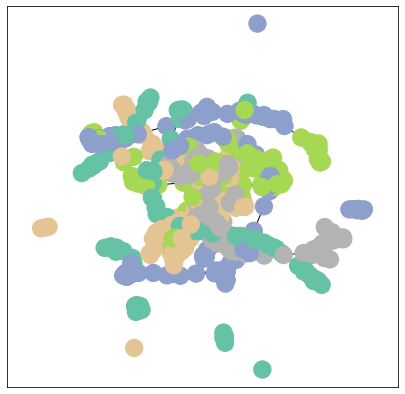

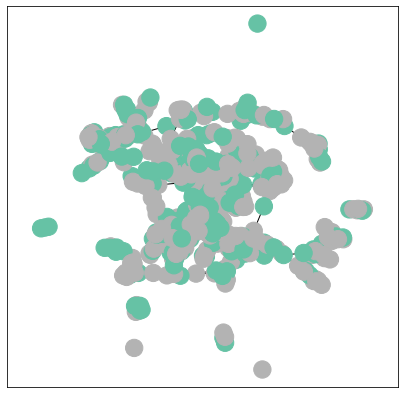

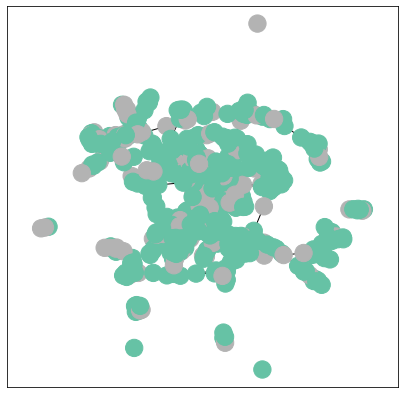

In [209]:
graph_stats(P)
print(P)
Q = to_networkx(P, to_undirected=True)
visualize_graph(Q, P.y)
visualize_graph(Q, P.train_mask)
visualize_graph(Q, P.validation_mask)

Set up the architecture. 12 neurons in the first layer, 6 in the second, 3 in the last (hoping to recover energy, angular momentum L and Lz, maybe). The graph information (the edge_index) is useless in reality, because each particle evolved separately. Or is it?

In [210]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(P.num_features, 12)
        self.conv2 = GCNConv(12, 6)
        self.conv3 = GCNConv(6, 3)
        self.classifier = Linear(3, n_centers) #numero di classi

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(6, 12)
  (conv2): GCNConv(12, 6)
  (conv3): GCNConv(6, 3)
  (classifier): Linear(in_features=3, out_features=5, bias=True)
)


Embedding shape: [500, 3]


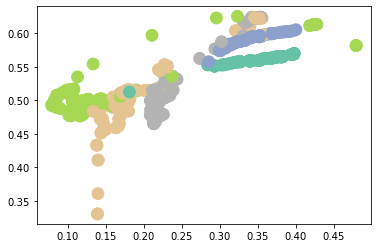

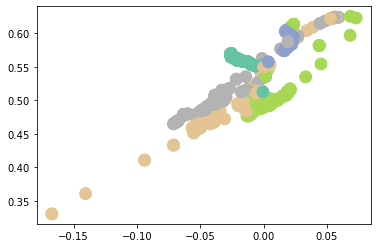

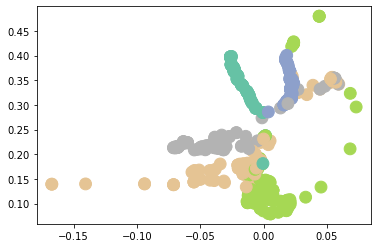

In [211]:
_, h = model(P.x, P.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=P.y)

Now training and validating on the validation set.

In [212]:
model = GCN()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

out, h = model(P.x, P.edge_index)

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss, h

epochs = np.arange(32001)
losses = np.zeros(shape=epochs.shape)
vallosses = np.zeros(shape=epochs.shape)
for epoch in epochs:
    loss, h = train(P)
    #visualize_embedding(h, color=P.y, epoch=epoch, loss=loss)
    outval, hval = model(P.x, P.edge_index)
    lossval = criterion(outval[P.validation_mask], P.y[P.validation_mask])
    losses[epoch] = loss.item()
    vallosses[epoch] = lossval.item()
    #print(epoch, losses[epoch], vallosses[epoch])

plt.plot(epochs, losses)
plt.plot(epochs, vallosses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [213]:
plt.plot(epochs, np.log(losses))
plt.plot(epochs, np.log(vallosses))
plt.show()

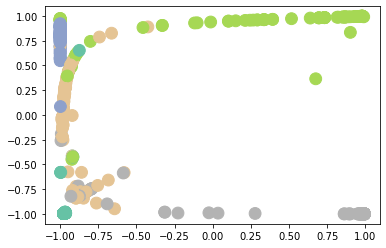

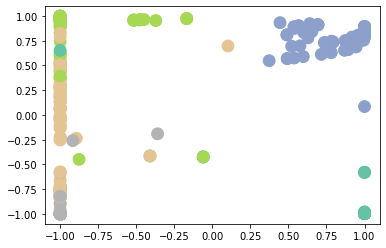

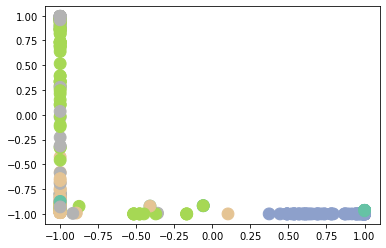

In [214]:
visualize_embedding(h, color=P.y, epoch=epoch, loss=loss)

0.9292035102844238


<AxesSubplot:>

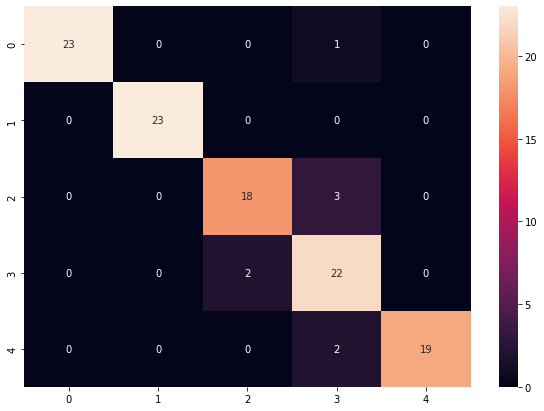

In [215]:
accuracy_metric = Accuracy()
confusion_matrix = ConfusionMatrix(5)
print(accuracy_metric(outval[P.validation_mask], P.y[P.validation_mask]).item())
plt.figure(figsize=(10,7))
sn.heatmap(confusion_matrix(outval[P.validation_mask], P.y[P.validation_mask]), annot=True)

Class predictions, (RA, Dec) on validation set


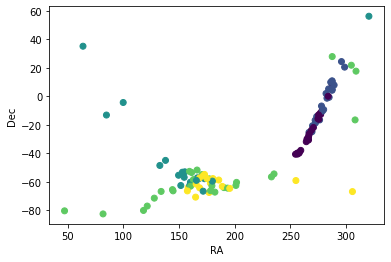

Truth, (RA, Dec) on validation set


Class predictions, (pmRA, pmDec) on validation set


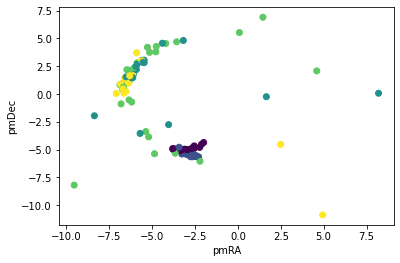

Truth, (pmRA, pmDec) on validation set


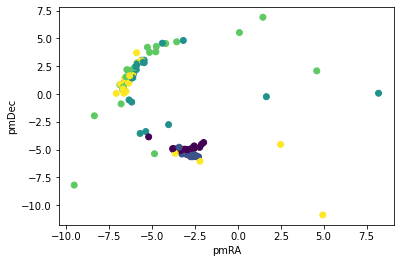

Class predictions, (RA, Dec) on validation set


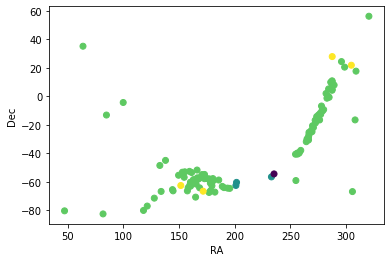

Truth, (pmRA, pmDec) on validation set


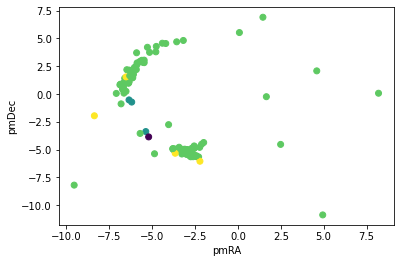

In [216]:
predictions = outval.detach().numpy()

print('Class predictions, (RA, Dec) on validation set')
plt.scatter(o.ra(T)[P.validation_mask], o.dec(T)[P.validation_mask], c=(np.argmax(predictions,1))[P.validation_mask])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()
print('Truth, (RA, Dec) on validation set')
plt.scatter(o.ra(T)[P.validation_mask], o.dec(T)[P.validation_mask], c=P.y[P.validation_mask])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()
print('Class predictions, (pmRA, pmDec) on validation set')
plt.scatter(o.pmra(T)[P.validation_mask], o.pmdec(T)[P.validation_mask], c=(np.argmax(predictions,1))[P.validation_mask])
plt.xlabel('pmRA')
plt.ylabel('pmDec')
plt.show()
print('Truth, (pmRA, pmDec) on validation set')
plt.scatter(o.pmra(T)[P.validation_mask], o.pmdec(T)[P.validation_mask], c=P.y[P.validation_mask])
plt.xlabel('pmRA')
plt.ylabel('pmDec')
plt.show()

miscla = (-(np.argmax(predictions,1)) + P.y.detach().numpy())
print('Class predictions, (RA, Dec) on validation set')
plt.scatter(o.ra(T)[P.validation_mask], o.dec(T)[P.validation_mask], c=miscla[P.validation_mask])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()
print('Truth, (pmRA, pmDec) on validation set')
plt.scatter(o.pmra(T)[P.validation_mask], o.pmdec(T)[P.validation_mask], c=miscla[P.validation_mask])
plt.xlabel('pmRA')
plt.ylabel('pmDec')
plt.show()

#visualize_graph(Q, outval.detach().numpy()[:,0], 'viridis')
#visualize_graph(Q, P.y)
#visualize_graph(Q, P.train_mask)
#visualize_graph(Q, P.validation_mask)

#labels

### Are the learned embedding coordinates related to energy and angular momentum?

In [221]:
embedding_coordinates = h.detach().cpu().numpy()

Embedding coordinate 0 VS energy at T


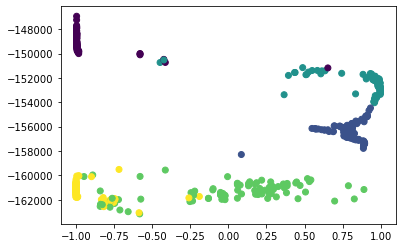

Embedding coordinate 0 VS angular momentum x at T


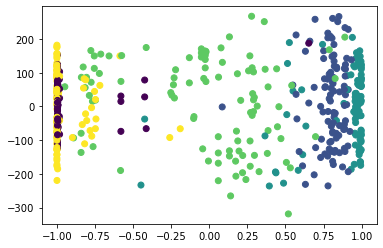

Embedding coordinate 0 VS angular momentum y at T


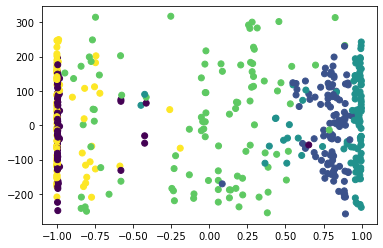

Embedding coordinate 0 VS angular momentum z at T


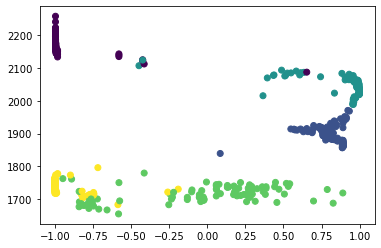

Embedding coordinate 0 VS angular momentum modulus at T


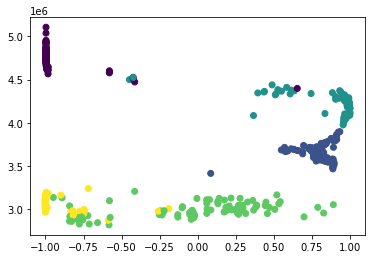

Embedding coordinate 0 VS energy at 0


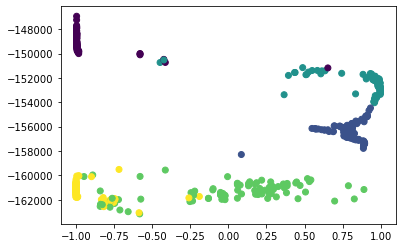

Embedding coordinate 0 VS angular momentum x at 0


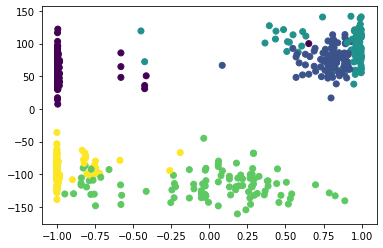

Embedding coordinate 0 VS angular momentum y at 0


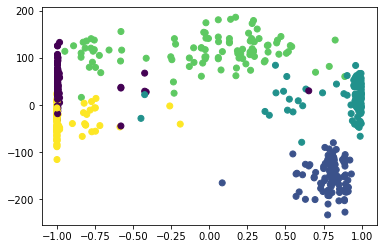

Embedding coordinate 0 VS angular momentum z at 0


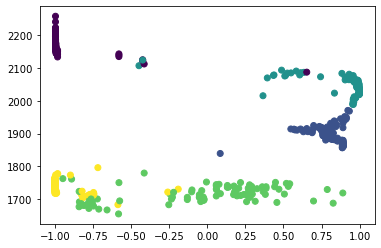

Embedding coordinate 0 VS angular momentum modulus at 0


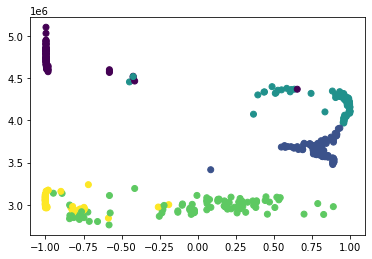

Embedding coordinate 1 VS energy at T


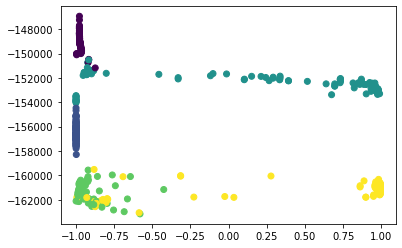

Embedding coordinate 1 VS angular momentum x at T


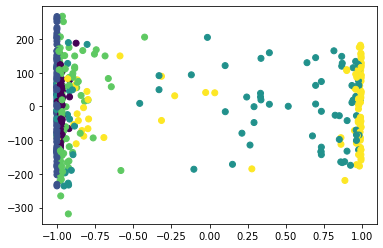

Embedding coordinate 1 VS angular momentum y at T


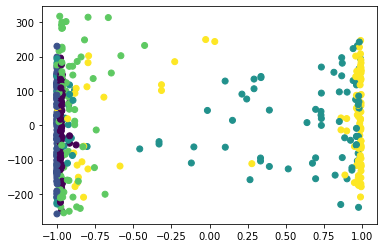

Embedding coordinate 1 VS angular momentum z at T


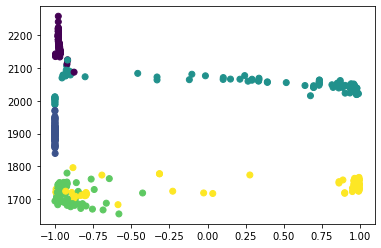

Embedding coordinate 1 VS angular momentum modulus at T


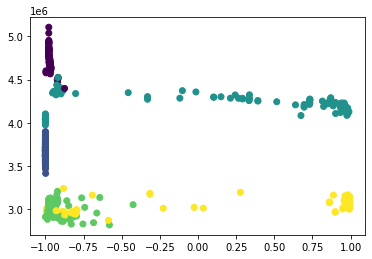

Embedding coordinate 1 VS energy at 0


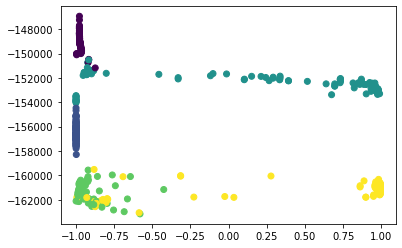

Embedding coordinate 1 VS angular momentum x at 0


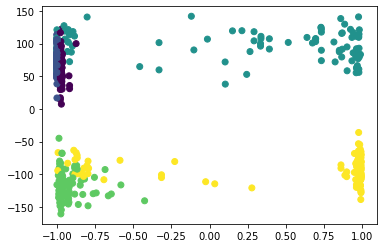

Embedding coordinate 1 VS angular momentum y at 0


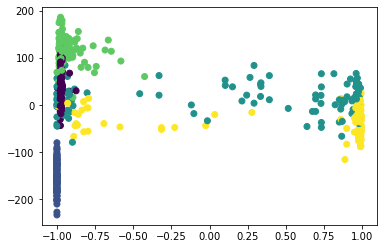

Embedding coordinate 1 VS angular momentum z at 0


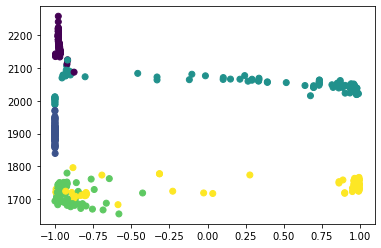

Embedding coordinate 1 VS angular momentum modulus at 0


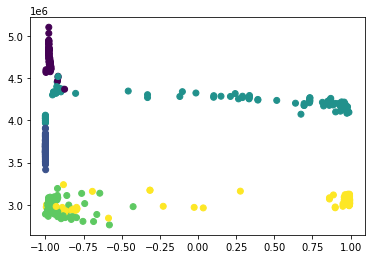

Embedding coordinate 2 VS energy at T


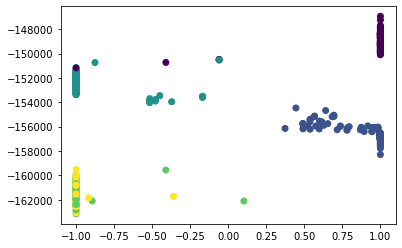

Embedding coordinate 2 VS angular momentum x at T


Embedding coordinate 2 VS angular momentum y at T


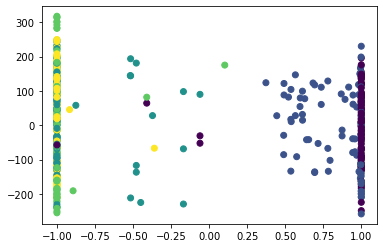

Embedding coordinate 2 VS angular momentum z at T


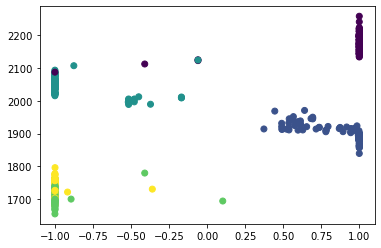

Embedding coordinate 2 VS angular momentum modulus at T


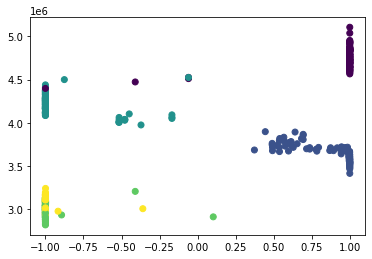

Embedding coordinate 2 VS energy at 0


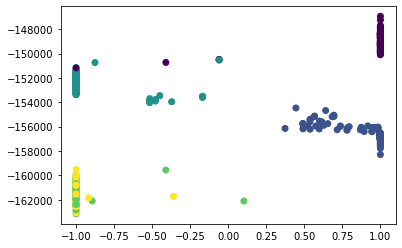

Embedding coordinate 2 VS angular momentum x at 0


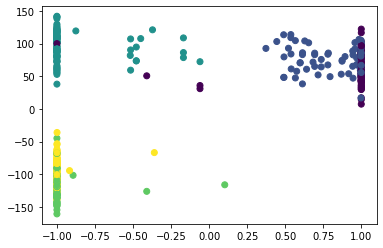

Embedding coordinate 2 VS angular momentum y at 0


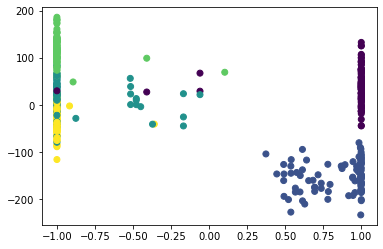

Embedding coordinate 2 VS angular momentum z at 0


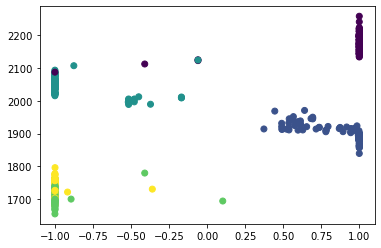

Embedding coordinate 2 VS angular momentum modulus at 0


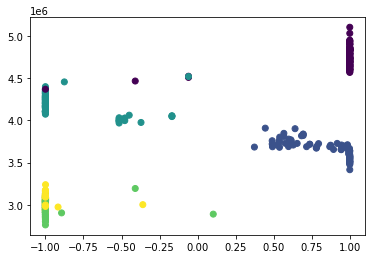

In [230]:
energy = o.E(T)
angular_momentum = o.L(T)
energy_0 = o.E(0)
angular_momentum_0 = o.L(0)

for i in range(3):
    print('Embedding coordinate ' + str(i) + ' VS energy at T')
    plt.scatter(embedding_coordinates[:,i], energy, c=labels)
    plt.show()
    print('Embedding coordinate ' + str(i) + ' VS angular momentum x at T')
    plt.scatter(embedding_coordinates[:,i], angular_momentum[:,0], c=labels)
    plt.show()
    print('Embedding coordinate ' + str(i) + ' VS angular momentum y at T')
    plt.scatter(embedding_coordinates[:,i], angular_momentum[:,1], c=labels)
    plt.show()
    print('Embedding coordinate ' + str(i) + ' VS angular momentum z at T')
    plt.scatter(embedding_coordinates[:,i], angular_momentum[:,2], c=labels)
    plt.show()
    Ltot = angular_momentum[:,2]*angular_momentum[:,2] + angular_momentum[:,1]*angular_momentum[:,1] + angular_momentum[:,0]*angular_momentum[:,0]
    print('Embedding coordinate ' + str(i) + ' VS angular momentum modulus at T')
    plt.scatter(embedding_coordinates[:,i], Ltot, c=labels)
    plt.show()    
    print('Embedding coordinate ' + str(i) + ' VS energy at 0')
    plt.scatter(embedding_coordinates[:,i], energy_0, c=labels)
    plt.show()
    print('Embedding coordinate ' + str(i) + ' VS angular momentum x at 0')
    plt.scatter(embedding_coordinates[:,i], angular_momentum_0[:,0], c=labels)
    plt.show()
    print('Embedding coordinate ' + str(i) + ' VS angular momentum y at 0')
    plt.scatter(embedding_coordinates[:,i], angular_momentum_0[:,1], c=labels)
    plt.show()
    print('Embedding coordinate ' + str(i) + ' VS angular momentum z at 0')
    plt.scatter(embedding_coordinates[:,i], angular_momentum_0[:,2], c=labels)
    plt.show()
    Ltot_0 = angular_momentum_0[:,2]*angular_momentum_0[:,2] + angular_momentum_0[:,1]*angular_momentum_0[:,1] + angular_momentum_0[:,0]*angular_momentum_0[:,0]
    print('Embedding coordinate ' + str(i) + ' VS angular momentum modulus at 0')
    plt.scatter(embedding_coordinates[:,i], Ltot_0, c=labels)
    plt.show()
